# TP4: Travail final

## Imports

In [46]:
from collections import defaultdict, Counter
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import yake

## Exploration du sous-corpus

In [47]:
path = "./corpus/txt/"
files = []

files = [f for f in os.listdir(path) if f.endswith('.txt')]

# Imprimer le nombre de fichiers identifiés
print(f"Total files: {len(files)}")
print(files)

Total files: 938
['KB_JB838_1957-04-28_01-00002.txt', 'KB_JB838_1957-03-27_01-00003.txt', 'KB_JB838_1962-05-12_01-00009.txt', 'KB_JB838_1959-10-17_01-00004.txt', 'KB_JB838_1963-09-26_01-00010.txt', 'KB_JB838_1962-07-21_01-00009.txt', 'KB_JB838_1959-10-27_01-00002.txt', 'KB_JB838_1958-01-04_01-00002.txt', 'KB_JB838_1964-09-25_01-00004.txt', 'KB_JB838_1963-01-25_01-00006.txt', 'KB_JB1051_1957-05-31_01-00003.txt', 'KB_JB838_1960-02-25_01-00007.txt', 'KB_JB838_1959-09-12_01-00003.txt', 'KB_JB838_1958-04-20_01-00003.txt', 'KB_JB838_1958-07-08_01-00003.txt', 'KB_JB1051_1957-08-13_01-00004.txt', 'KB_JB838_1958-08-31_01-00003.txt', 'KB_JB838_1964-04-19_01-00002.txt', 'KB_JB838_1958-06-17_01-00003.txt', 'KB_JB1051_1958-06-27_01-00003.txt', 'KB_JB838_1958-03-18_01-00003.txt', 'KB_JB838_1962-12-12_01-00001.txt', 'KB_JB838_1957-07-10_01-00002.txt', 'KB_JB838_1964-09-24_01-00002.txt', 'KB_JB838_1958-09-26_01-00020.txt', 'KB_JB838_1962-04-26_01-00008.txt', 'KB_JB838_1957-03-23_01-00001.txt', 'KB_JB8

In [48]:
# Quelques stats

count_year = defaultdict(int)
count_month = defaultdict(int)
count_decade = defaultdict(int)
count_newspapers = defaultdict(int)
covered_years = set()

for f in files:
    if "_" in f and f.endswith("txt") and f != "_README.txt":
        elems = f.split("_")
        
        newspaper = elems[1]
        
        year = elems[2].split("-")[0]
        covered_years.add(year)
        decade = year[:3] + "0s"
        
        month = int(elems[2].split("-")[1])
        
        count_decade[decade] += 1
        count_newspapers[newspaper] += 1
        count_month[month] += 1
    else:
        print(f"Anomalous file: {f}")

In [49]:
print(f"Il y a {count_newspapers['JB838']} exemplaires du journal Le Soir et {count_newspapers['JB1051']} exemplaires de Le Drapeau rouge")

Il y a 701 exemplaires du journal Le Soir et 237 exemplaires de Le Drapeau rouge


In [50]:
files = [f for f in os.listdir(path) if f.lower().endswith(".txt")]

rows = []
date_re = re.compile(r"(\d{4})-(\d{2})")

for f in files:
    if "_" not in f:
        continue

    elems = f.split("_")
    if len(elems) < 3:
        continue

    journal = elems[1]

    m = date_re.search(f)
    if not m:
        continue

    year = int(m.group(1))
    month = int(m.group(2))

    rows.append({
        "journal": journal,
        "year": year,
        "month": month,
        "year_month": f"{year}-{month:02d}"
    })

df = pd.DataFrame(rows)

print(df.head())
print(df["journal"].value_counts())


  journal  year  month year_month
0   JB838  1957      4    1957-04
1   JB838  1957      3    1957-03
2   JB838  1962      5    1962-05
3   JB838  1959     10    1959-10
4   JB838  1963      9    1963-09
JB838     701
JB1051    237
Name: journal, dtype: int64


In [51]:
year_counts = (
    df.groupby(["year", "journal"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

print(year_counts)


journal  JB1051  JB838
year                  
1957         50    124
1958         54    118
1959         41     85
1960         62     92
1961         30     58
1962          0     59
1963          0     76
1964          0     89


<Figure size 1200x500 with 0 Axes>

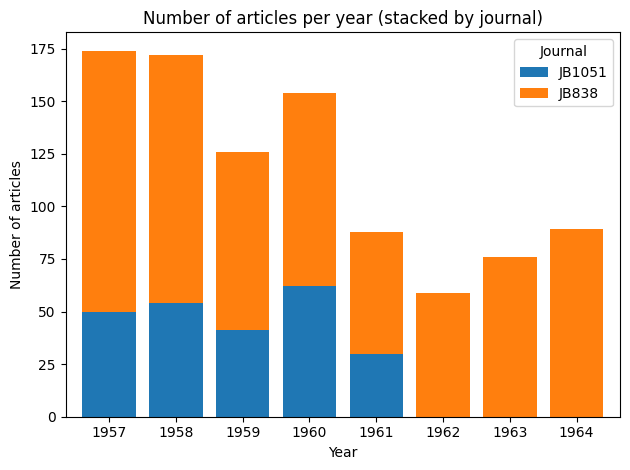

In [52]:
plt.figure(figsize=(12, 5))

year_counts.plot(
    kind="bar",
    stacked=True,
    width=0.8
)

plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Number of articles per year (stacked by journal)")
plt.xticks(rotation=0)

plt.legend(title="Journal")
plt.tight_layout()
plt.show()


In [53]:
counts = (
    df.groupby(["journal", "year", "month", "year_month"])
      .size()
      .reset_index(name="n_articles")
      .sort_values(["year", "month"])
)

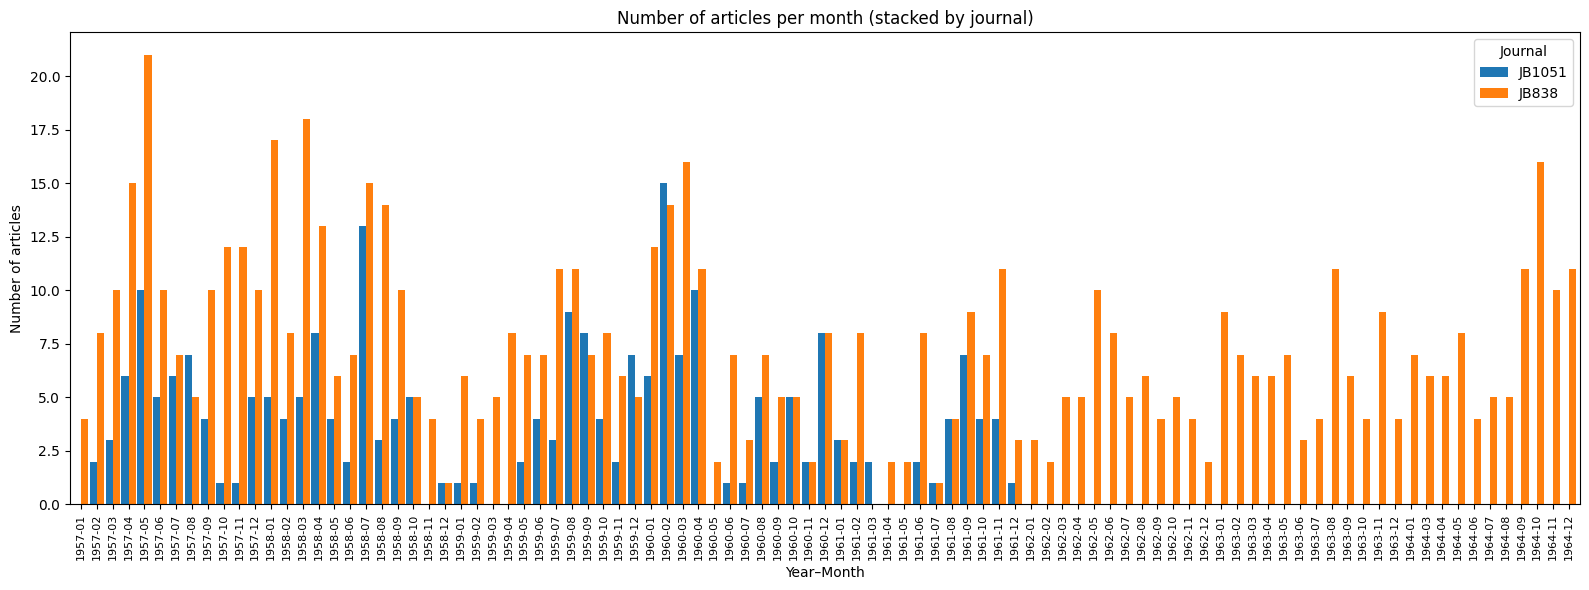

In [54]:
df["year_month"] = pd.to_datetime(df["year_month"], format="%Y-%m")
df = df.sort_values("year_month")
df["year_month_str"] = df["year_month"].dt.strftime("%Y-%m")

ym_counts = (
    df.groupby(["year_month_str", "journal"])
      .size()
      .unstack(fill_value=0)
)

# Plot stacked bars
ax = ym_counts.plot(kind="bar", stacked=False, figsize=(16, 6), width=0.9)

ax.set_xlabel("Year–Month")
ax.set_ylabel("Number of articles")
ax.set_title("Number of articles per month (stacked by journal)")

plt.xticks(rotation=90, fontsize=8)
plt.legend(title="Journal")
plt.tight_layout()
plt.show()


## Analyse du sous-corpus

### Analyse de vocabulaire du contenu des articles

In [55]:
all_path = "./corpus/output/all.txt"

with open(all_path, "w", encoding="utf-8") as output_file:
    for file in os.listdir(path):
        if file.endswith(".txt"):
            with open(os.path.join(path, file), "r", encoding="utf-8") as f:
                content = f.read()
                output_file.write(content + "\n")

In [76]:
all_path = "./corpus/output/all_jb1051.txt"

with open(all_path, "w", encoding="utf-8") as output_file:
    for file in os.listdir(path):
        if file.endswith(".txt") and file.split("_")[1]=="JB1051":
            with open(os.path.join(path, file), "r", encoding="utf-8") as f:
                content = f.read()
                output_file.write(content + "\n")

In [56]:
# Word Count
!wc ./corpus/output/all.txt

# 938 lines
# 5721789 words
# 35844297 bytes

     938  5721789 35844297 ./corpus/output/all.txt


In [57]:
# Getting the content
text_all = []

with open(all_path, 'r', encoding='utf-8') as f:
    text_all = f.read()

In [58]:
# Tokenization in file
words = nltk.wordpunct_tokenize(text_all)
voc = set(words)
print(f"{len(words)} words found in file ({len(voc)} different word forms)")


7569835 words found in file (299943 different word forms)


In [59]:
words[:20]

['La',
 'Comédie',
 '-',
 'Française',
 'au',
 'théâtre',
 'du',
 'Parc',
 '«',
 'La',
 'seconde',
 'Surprise',
 'de',
 'l',
 '’',
 'Amour',
 '»',
 'et',
 '«',
 'Crispin']

In [60]:
# Listing stopwords
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "ville", "rossel", "dem"]

add_sw = ["Brux", "ecrire","écr", "ecr","brux", "BRUX","bruxelles", "Là","Av", "AV",
       "vend", "prix", "rue", "bon", "Ch", "CH", "ST", "Chff",
       "Tél", "tél", "très", "ans", "PL", "pl", "St",
       "téléph","gar","app", "trav", "ch", "CH", "Ch","pr", "Si", "si", "SI",
       "maison", "ag", "st", "fr", "louer", "conf", "garage", "jard", "vendre", "adr", "chf", "comment",
       "villa", "bel", "av", "km", "AV", "Av", "do", "ét", "avenue", "gr", "inst", "cond",
       "jardin", "rez", "ec", "él", "tél", "moderne", "petite", "belle", "mod", "où",
       "géomètre", "chauf", "télé", "chauff", "cave", "agence", "ii", "appart", "bd", "xl", "télép", "têl", "br",
       "tr", "studio", "leç", "chaussée", "bur", "appartem", "caves", "adrcs", "faç",
       "place", "cherche", "sal", "bain", "référ", "etc", "prés", "ds", "lo", "téléphone", "réf", "meub", "concierge",
       "comm", "dcm", "louise", "ot", "jo", "francs", "lr", "jne", "ouvr", "aven", "cuisine",
       "no", "cyl", "alors", "rr", "sér", "références", "ts", "ad", "référenc", "tt",
       "lcr", "mol", "dlt", "ll", "nf", "pers", "leurs", "vers", "quelques", "grand", "peu", "grande",
       "très", "toute", "soir"
       ]
sw.extend(add_sw)
sw = set(sw)

### Calcul de la taille du vocabulaire

In [61]:
def clean_text(input_file, output_file):
    output = open(output_file, "w", encoding='utf-8')
    with open(all_path,'r', encoding='utf-8') as f:
        for line in f:
            words = nltk.wordpunct_tokenize(line)
            kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
            kept_string = " ".join(kept)
            output.write(kept_string + '\n')
    return f'The output has been written in {output_file}!'

In [62]:
all_clean_path = "./corpus/output/all_clean.txt"

clean_text(all_path, all_clean_path)

'The output has been written in ./corpus/output/all_clean.txt!'

In [63]:
text_clean = []

with open(all_clean_path, 'r', encoding='utf-8') as f:
    text_clean = f.read()

words_kept = nltk.wordpunct_tokenize(text_clean)
voc_kept = set(words_kept)

print(f"{len(words_kept)} words kept ({len(voc_kept)} different word forms)")

2749054 words kept (241011 different word forms)


In [64]:
# Récupération des mots les plus fréquents
fdist = nltk.FreqDist(words_kept)
fdist.most_common(20)

[('pays', 7217),
 ('président', 6485),
 ('ministre', 6249),
 ('gouvernement', 5958),
 ('général', 4783),
 ('cours', 4296),
 ('etats', 4296),
 ('politique', 4096),
 ('temps', 4035),
 ('premier', 4003),
 ('part', 3880),
 ('unis', 3768),
 ('france', 3683),
 ('avant', 3484),
 ('belgique', 3477),
 ('guerre', 3449),
 ('conseil', 3444),
 ('monde', 3422),
 ('parti', 3390),
 ('heures', 3243)]

<AxesSubplot: xlabel='Samples', ylabel='Cumulative Counts'>

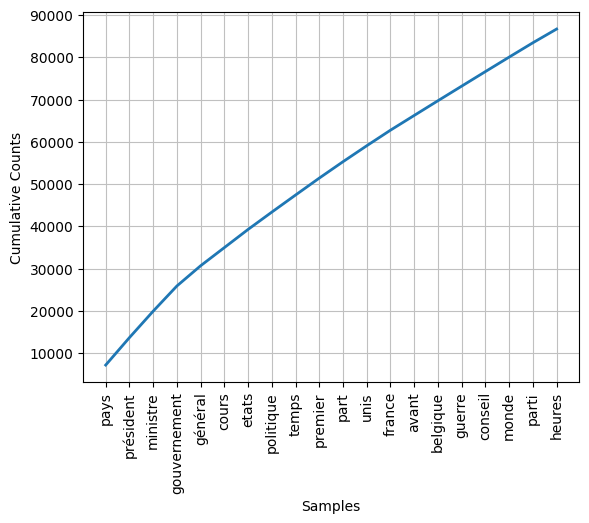

In [65]:
# Plot: les n mots les plus fréquents
n = 20
fdist.plot(n, cumulative=True)

In [66]:
print(fdist.get("bombe"))
print(fdist.get("atomique"))
print(fdist.get("arme"))
print(fdist.get("nucléaire"))


1774
2163
436
1026


In [67]:
fdist.hapaxes()[:30]

['nviefniont',
 'ahmam',
 'épouseront',
 'perdriere',
 'quotidieh',
 'embarrassantes',
 'souriez',
 'teune',
 'transvalienne',
 'complimenteur',
 'kaekebroeck',
 'carne',
 'gaudeau',
 'labru',
 'tacteur',
 'impertinences',
 'ganeau',
 'éfimser',
 'friponnerie',
 'vitray',
 'baconnet',
 'samie',
 'grellier',
 'galabru',
 'respens',
 'bellin',
 'vintimilles',
 'evees',
 'phonocardiographlc',
 'gnostic']

In [68]:
# Identification des mots les plus longs
n = 30
sorted(voc, key=len, reverse=True)[:n]

['Îîîïîîîîîîïrîîtîîîîiîïrîiîïîtîîîîtîîîïtsîîïïîïîsîîirxtîisîîîtstsîîîiîîîîîîîsîtîïïtïîîîtjîîiîîîjju',
 'iiitttiiiitittttstxiitizsiîiKiiîiiiitîitiittiittttitttttstiXtttttiîtstiiîUiiainutiütiituu',
 'dlittitîîiiutiiiîiiîîiiiiiititiiiiiuiiliiXiiîiyiiiitttiiztiititïiiîiiittînîiitnxîiiimuii',
 'îîîîMsîtrîiîSîKîjHîîîîttîiSîîjîSîjîaîîHttîîJîîJtttnjttnttîJîîîtainJîtttsiîsiRtasiiiii',
 'tmDœœtœœttætttmBttmmmummHamîJumumtttmjmircttmmmmœmœtrcHafmBmmmummœaœœmtutmHmîJtmmumu',
 'ïittttttittttttiiitttiitittixttttittiiiinttittitmiiittttitttttttuitMtmtttmttnuœitêi',
 'iütîîtJtitîîJttîtinîtittiîmtttîîîttnîttHttiJîJtîttJîtttiîititiîtjntîtjmtîtimtimum',
 'iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiniiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii',
 'txtitttxnittttttnKttttttittitttmtttxtxiintuiittttnimtitttxtximtttxtttittittm',
 'tîJîjtJiîtîJîîtJtîttitKJùijnjiatsttîîitîîjmtKîtîJtttînîttmtKîîïsîrtîjtttttn',
 'wtttttititttiimnmttttmwttttfflttmtffltmfflttfflnffltKfflttmtttfflmfflmttmi',
 'iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii

## Extraction de mots clés

In [69]:
# Instantier l'extracteur de mots clés
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

In [70]:
keywords_clean = kw_extractor.extract_keywords(text_clean)


In [71]:
print(keywords_clean)

[('ministre affaires étrangères', 3.568587277805183e-10), ('président etats unis', 5.295808327587381e-10), ('etats unis bretagne', 1.0702106058097255e-09), ('ministre affaires économiques', 1.14945369382075e-09), ('gouvernement etats unis', 1.5844066851820332e-09), ('cours conférence presse', 1.6652237295493024e-09), ('voir suite page', 1.699027031376087e-09), ('président conseil soviétique', 2.0486751158657064e-09), ('ministre défense nationale', 2.2875761414134323e-09), ('secrétaire etat américain', 2.930000460813521e-09), ('ministre travaux publics', 2.9637208787488765e-09), ('etats unis pays', 3.0460030202183205e-09), ('bretagne etats unis', 3.2543138829724305e-09), ('ambassadeur etats unis', 3.3391806430555522e-09), ('etats unis france', 3.3508639829286666e-09), ('etats unis président', 3.651320478494458e-09), ('vice président conseil', 3.735770355910703e-09), ('parti communiste belgique', 3.7464476919133844e-09), ('bombe atomique française', 3.752760535660859e-09), ('chef gouvern

In [72]:
# Garder les bigrammes du fichier intégré
kept = []
for kw, score in keywords_clean:
    words = kw.split()
    if len(words) >= 2:
        kept.append(kw)
print(f"{all_clean_path} mentions these keywords:")
for n in kept:
    print(n)

./corpus/output/all_clean.txt mentions these keywords:
ministre affaires étrangères
président etats unis
etats unis bretagne
ministre affaires économiques
gouvernement etats unis
cours conférence presse
voir suite page
président conseil soviétique
ministre défense nationale
secrétaire etat américain
ministre travaux publics
etats unis pays
bretagne etats unis
ambassadeur etats unis
etats unis france
etats unis président
vice président conseil
parti communiste belgique
bombe atomique française
chef gouvernement soviétique
président conseil ministres
tient lieu part
conférence ministres affaires
ministre ministre affaires
etats unis union
ministre congo belge
etats unis
atomique etats unis
soviétique etats unis
cours dernières années
france etats unis
ministre santé publique
pays pays pays
déclaré etats unis
avis tient lieu
ministre soviétique affaires
pays marché commun
nucléaires etats unis
ancien président conseil
guerre etats unis
ministre instruction publique
etats unis gouvernement

In [73]:
for n in kept: 
    if "bombe" in n or "atomique" in n or "nucléaire" in n or "arme" in n:
     print(n)

bombe atomique française
atomique etats unis
nucléaires etats unis


In [74]:
# Find keywords per file linked to the specific year keeping bigrams
#for f in sorted(files):
#    text = open(os.path.join(path, f), 'r', encoding="utf-8").read()
#    keywords = kw_extractor.extract_keywords(text)
#    kept = []
#    for kw, score in keywords:
#        words = kw.split()
#        if len(words) == 2:
#            kept.append(kw)
#    print(f"{f} mentions these keywords: {', '.join(kept)}...")